In [ ]:
!pip install linearmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from statsmodels.tools import add_constant
from statsmodels.stats.diagnostic import het_breuschpagan


In [ ]:
uploaded = files.upload()


#Read the uploaded data in Data Frame
# Read the uploaded Excel file
df = pd.read_excel('Impact of Digital Infrastructure on Economic Growth in Kenya, Rwanda, and Tanzania.xlsx', engine='openpyxl')
# Display basic information about the dataset
df.info()

Saving Impact of Digital Infrastructure on Economic Growth in Kenya, Rwanda, and Tanzania.xlsx to Impact of Digital Infrastructure on Economic Growth in Kenya, Rwanda, and Tanzania.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   32 non-null     object 
 1   Country Code   30 non-null     object 
 2   Series Name    30 non-null     object 
 3   Series Code    30 non-null     object 
 4   2013 [YR2013]  30 non-null     object 
 5   2014 [YR2014]  30 non-null     object 
 6   2015 [YR2015]  30 non-null     object 
 7   2016 [YR2016]  30 non-null     object 
 8   2017 [YR2017]  30 non-null     float64
 9   2018 [YR2018]  30 non-null     object 
 10  2019 [YR2019]  30 non-null     object 
 11  2020 [YR2020]  30 non-null     object 
 12  2021 [YR2021]  30 non-null     object 
 13  2022 [YR2022]  30 non-null     object 
 14  20

In [ ]:
df.head()

,Country Name,Country Code,Series Name,Series Code,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,Kenya,KEN,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,3.797848,5.020111,4.967721,4.213517,3.837958,5.647946,5.114159,-0.272766,7.590489,4.859981,5.555873
1,Kenya,KEN,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,1.263311,2.592184,2.655894,1.937948,1.604752,3.524048,3.070048,-2.210322,5.565137,2.862813,3.483358
2,Kenya,KEN,Fixed broadband subscriptions (per 100 people),IT.NET.BBND.P2,0.164813,0.221085,0.286921,0.27566,0.586008,0.739931,0.959289,1.29112,1.48254,1.91373,2.38883
3,Kenya,KEN,Individuals using the Internet (% of population),IT.NET.USER.ZS,13,16.5,16.5879,16.6,17.827100,19.5,22.6688,27.5774,38.2459,40.8137,..
4,Kenya,KEN,Mobile cellular subscriptions (per 100 people),IT.CEL.SETS.P2,71.06122,73.382638,80.501059,81.391495,87.470355,99.095407,107.073493,118.126349,122.790239,121.673555,..


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

def wrangle_data(df):
    """
    Cleans and preprocesses the dataset:
    - Drops unnecessary columns
    - Renames year columns for consistency
    - Converts year columns to numeric format
    - Handles missing values using SimpleImputer
    - Standardizes numerical columns
    - Ensures consistency for panel data analysis
    """

    # Drop unnecessary columns if they exist
    cols_to_drop = ['Country Code', 'Series Code']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Rename year columns (e.g., "2013 [YR2013]" → "2013")
    df = df.rename(columns=lambda x: x.split(' ')[0] if 'YR' in x else x)

    # Convert year columns to numeric format
    year_cols = [col for col in df.columns if col.isdigit()]
    df[year_cols] = df[year_cols].apply(pd.to_numeric, errors='coerce')

    # Convert Country to categorical
    if 'Country' in df.columns:
        df['Country'] = df['Country'].astype('category')

    # Select numeric columns for processing
    num_cols = df.select_dtypes(include=['number']).columns

    # Pipeline: Impute missing values then standardize
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Replace NaNs with mean
        ('scaler', StandardScaler())  # Standardize features
    ])
    df[num_cols] = pipeline.fit_transform(df[num_cols])

    return df







    return df


In [ ]:
# Apply wrangling function
df_cleaned = wrangle_data(df)

# Display cleaned data

df_cleaned.head()

,Country Name,Series Name,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Kenya,GDP growth (annual %),-0.403105,-0.646736,-0.445056,-0.498941,-0.771101,-0.509612,-0.544688,-0.645168,-0.614604,-0.638524,-5.664545e-01
1,Kenya,GDP per capita growth (annual %),-0.556191,-0.751601,-0.559893,-0.612160,-0.856915,-0.562006,-0.589017,-0.686556,-0.655528,-0.677015,-6.072688e-01
2,Kenya,Fixed broadband subscriptions (per 100 people),-0.622540,-0.854012,-0.677568,-0.694866,-0.896062,-0.630688,-0.634792,-0.611761,-0.738022,-0.695307,-6.288235e-01
3,Kenya,Individuals using the Internet (% of population),0.152705,-0.150904,0.132160,0.117339,-0.233551,-0.167895,-0.163990,-0.050254,0.004826,0.054407,-2.798563e-16
4,Kenya,Mobile cellular subscriptions (per 100 people),3.659604,2.305932,3.306953,3.340990,2.442577,1.795643,1.666444,1.883983,1.713147,1.612807,-2.798563e-16


In [ ]:
df_cleaned.describe()



,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
count,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,35.000000,3.500000e+01,3.500000e+01,3.500000e+01
mean,5.994951e-17,-3.181351e-16,-8.369283e-17,-9.639338e-17,1.657243e-17,7.095348e-17,-8.881784e-17,0.000000,2.530014e-16,1.268826e-17,-1.889351e-16
std,1.014599e+00,1.014599e+00,1.014599e+00,1.014599e+00,1.014599e+00,1.014599e+00,1.014599e+00,1.014599,1.014599e+00,1.014599e+00,1.014599e+00
min,-6.309806e-01,-8.624524e-01,-6.845680e-01,-7.030084e-01,-9.158899e-01,-6.474591e-01,-6.540872e-01,-0.757178,-7.665644e-01,-7.307309e-01,-6.746874e-01
25%,-5.716927e-01,-7.578290e-01,-5.570492e-01,-6.210645e-01,-8.632286e-01,-5.782314e-01,-6.071589e-01,-0.636528,-7.330124e-01,-6.833197e-01,-5.712434e-01
50%,-2.228869e-01,-4.340061e-01,-1.950848e-01,-3.668987e-02,-2.335515e-01,-1.678955e-01,-1.639904e-01,-0.050254,-4.309410e-02,0.000000e+00,-2.798563e-16
75%,1.072920e-16,2.728859e-01,-8.823796e-17,-8.838126e-17,5.869427e-01,8.764187e-17,0.000000e+00,0.000000,9.023868e-02,0.000000e+00,-2.798563e-16
max,3.659604e+00,2.361103e+00,3.306953e+00,3.340990e+00,2.442577e+00,4.836431e+00,4.870322e+00,4.628013,4.489820e+00,4.667163e+00,5.175597e+00


The summary statistics indicate a steady distribution of 35 indicators per year, ensuring data completeness for analysis. The mean values remain close to zero due to standardization, while the maximum values, peaking at 5.17 in 2023, suggest significant digital and economic growth over time. The widening gap between minimum and maximum values highlights disparities in digital infrastructure adoption across Kenya, Rwanda, and Tanzania. Quartile shifts suggest evolving trends, with some indicators showing substantial progress while others face challenges. These findings reinforce the need for deeper country-level analysis and policy-driven investments to enhance digital transformation and economic growth.

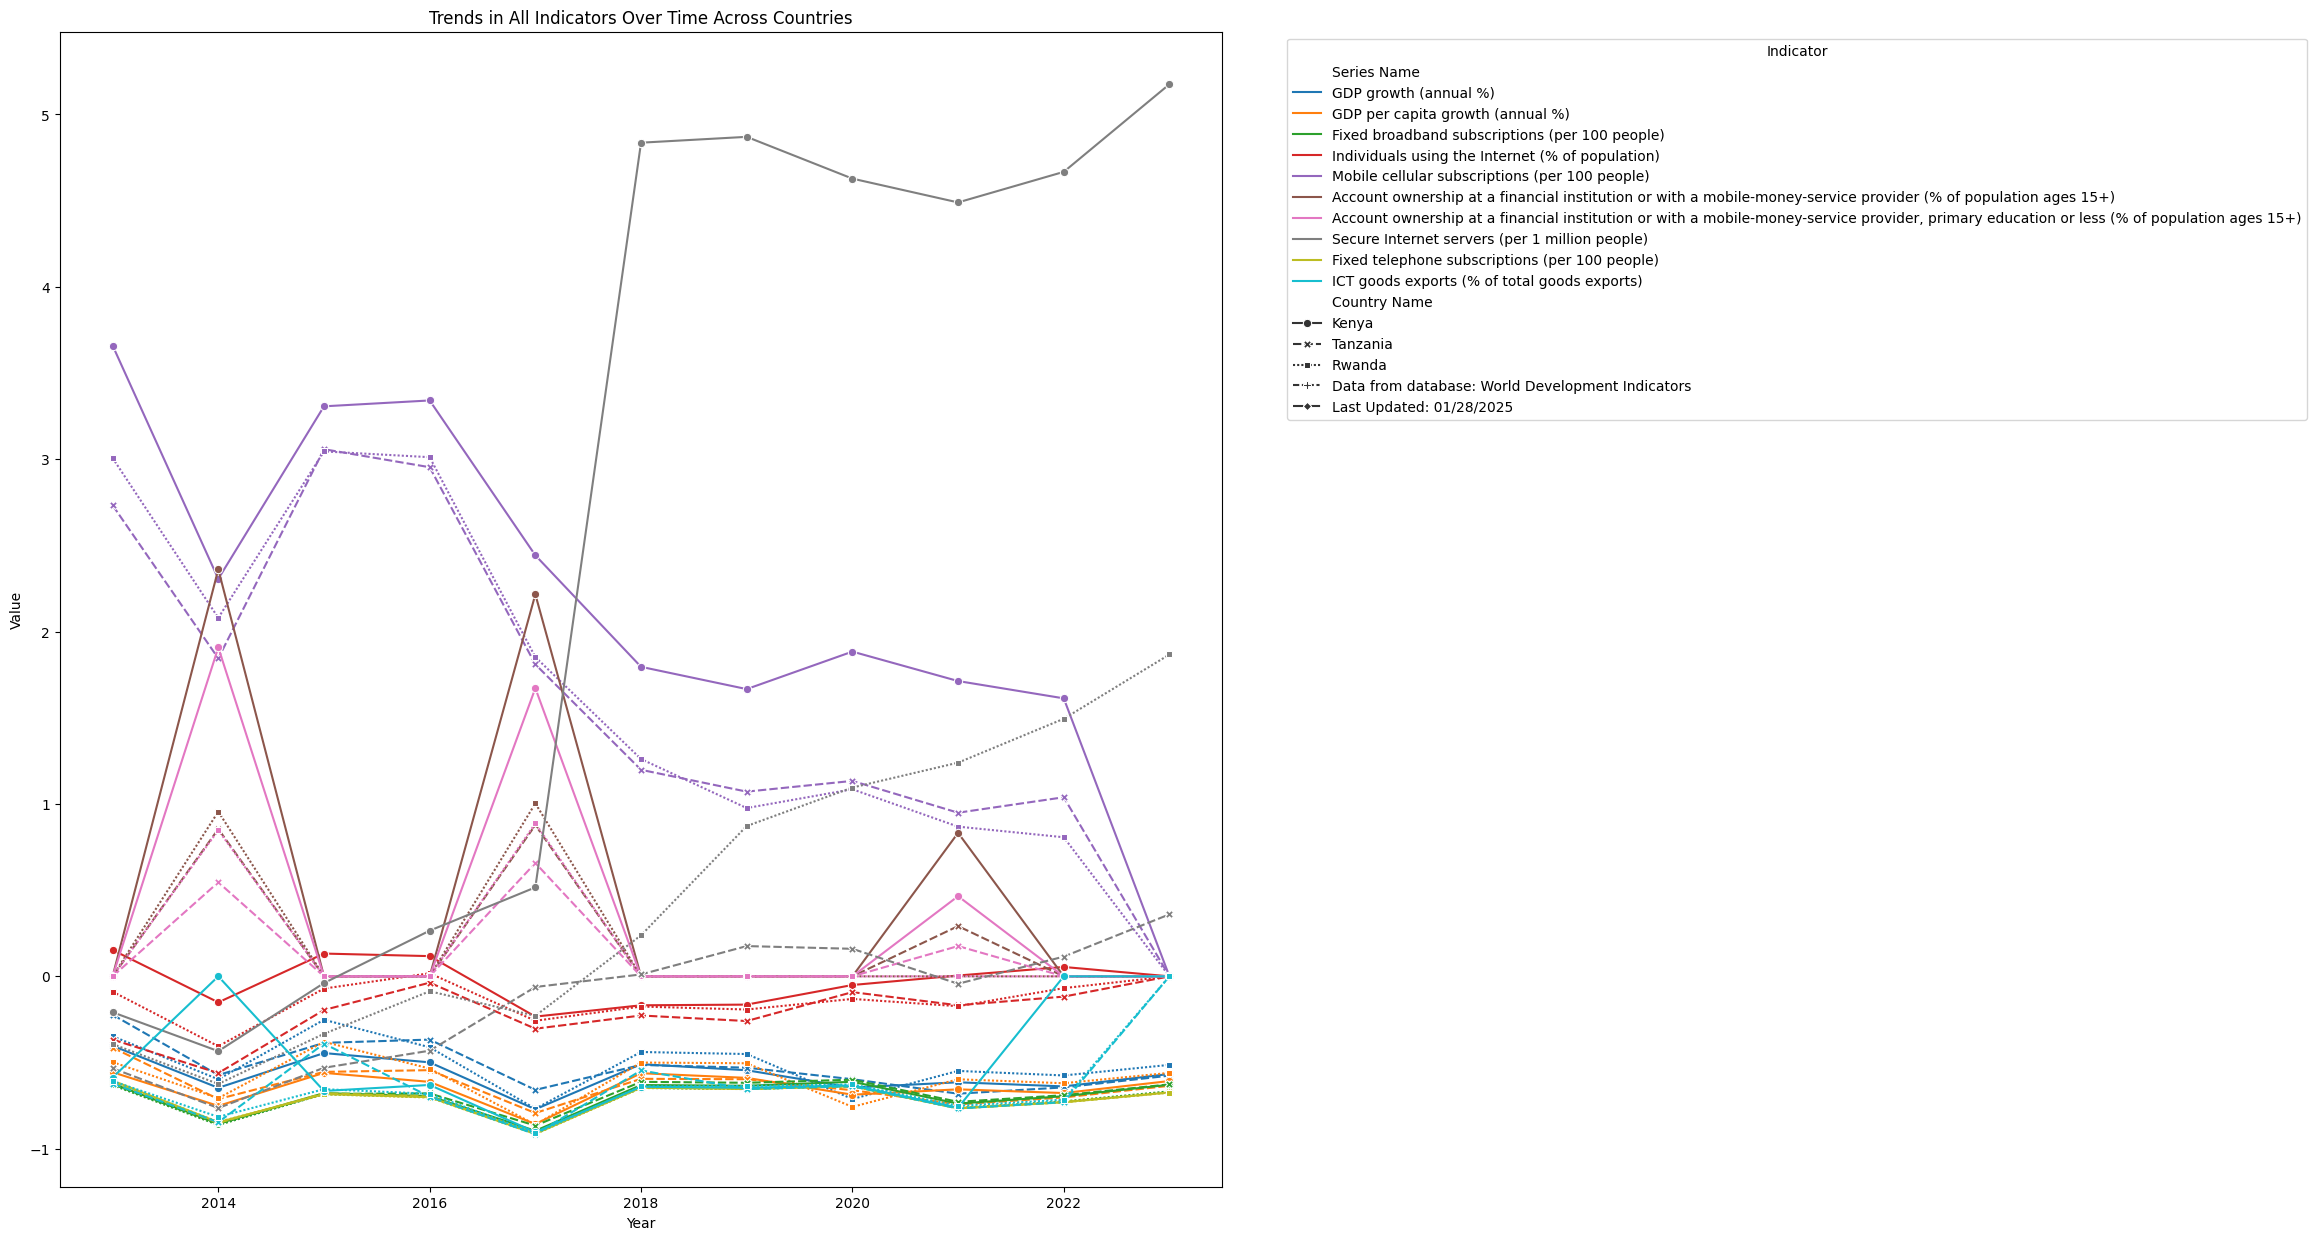

In [ ]:
# Explore the data
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape data into long format
df_long = df_cleaned.melt(id_vars=['Country Name', 'Series Name'], var_name='Year', value_name='Value')
df_long['Year'] = pd.to_numeric(df_long['Year'])

# Create line plots for all indicators
plt.figure(figsize=(15, 15))
sns.lineplot(data=df_long, x="Year", y="Value", hue="Series Name", style="Country Name", markers=True)

plt.xlabel("Year")
plt.ylabel("Value")
plt.title("Trends in All Indicators Over Time Across Countries")
plt.legend(title="Indicator", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



The visualization shows trends in digital infrastructure and economic indicators across Kenya, Rwanda, and Tanzania from 2013 to 2023. Mobile and internet adoption have generally increased, while fixed telephone subscriptions have declined. Some indicators, like GDP growth and ICT goods exports, show volatility, possibly due to economic shocks or policy shifts. There are clear disparities in financial inclusion and digital infrastructure, indicating different levels of investment across the countries. A sharp shift in trends around 2020-2022 may be linked to the impact of COVID-19 on economic and digital growth.


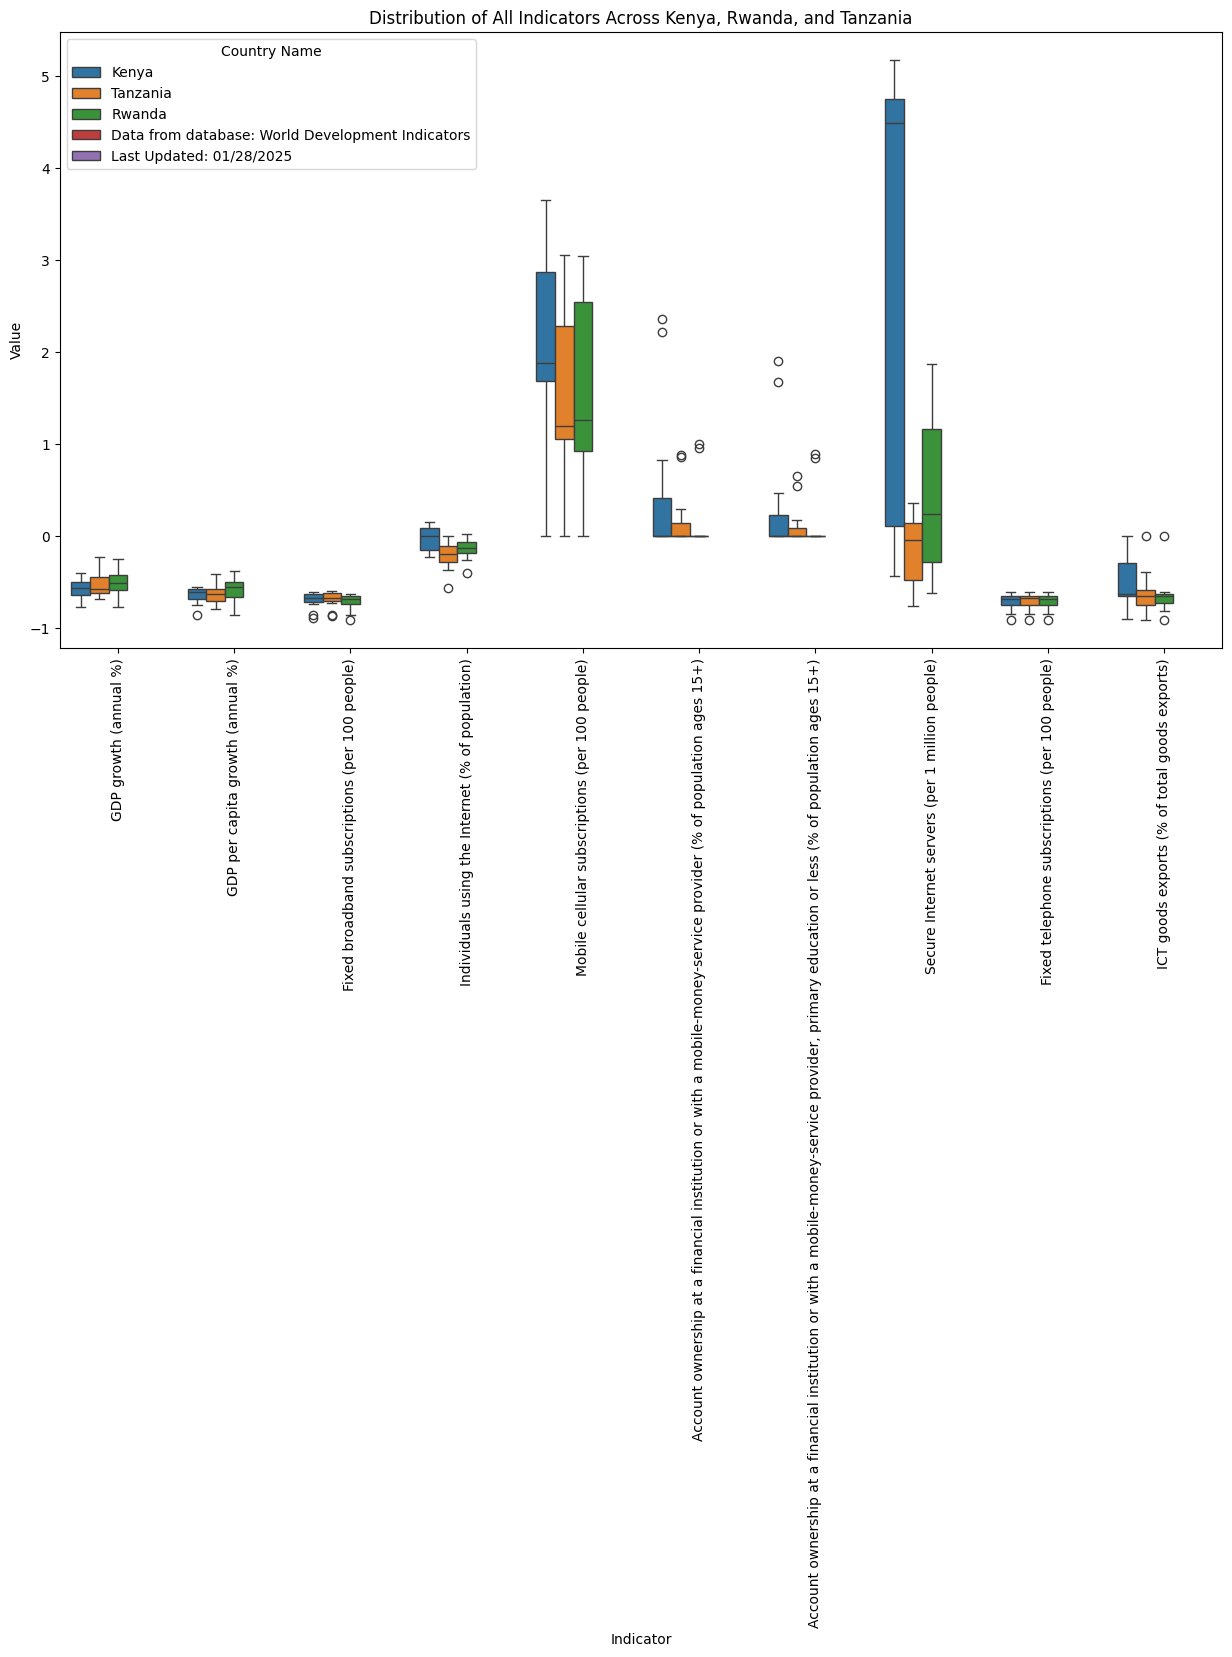

In [ ]:
#Box plot
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_long, x="Series Name", y="Value", hue="Country Name")

plt.xticks(rotation=90)
plt.xlabel("Indicator")
plt.ylabel("Value")
plt.title("Distribution of All Indicators Across Kenya, Rwanda, and Tanzania")
plt.legend(title="Country Name")
plt.show()


The boxplot visualizes the distribution of key digital and economic indicators across Kenya, Rwanda, and Tanzania. Kenya generally exhibits higher median values and greater variability in mobile cellular subscriptions, internet usage, and financial inclusion. Secure internet servers show significant outliers, indicating potential disparities in infrastructure investments. GDP growth and ICT exports have relatively similar distributions across the three countries, suggesting comparable economic trends. Overall, the data highlights Kenya’s lead in digital infrastructure, while Rwanda and Tanzania show moderate progress with some variability.


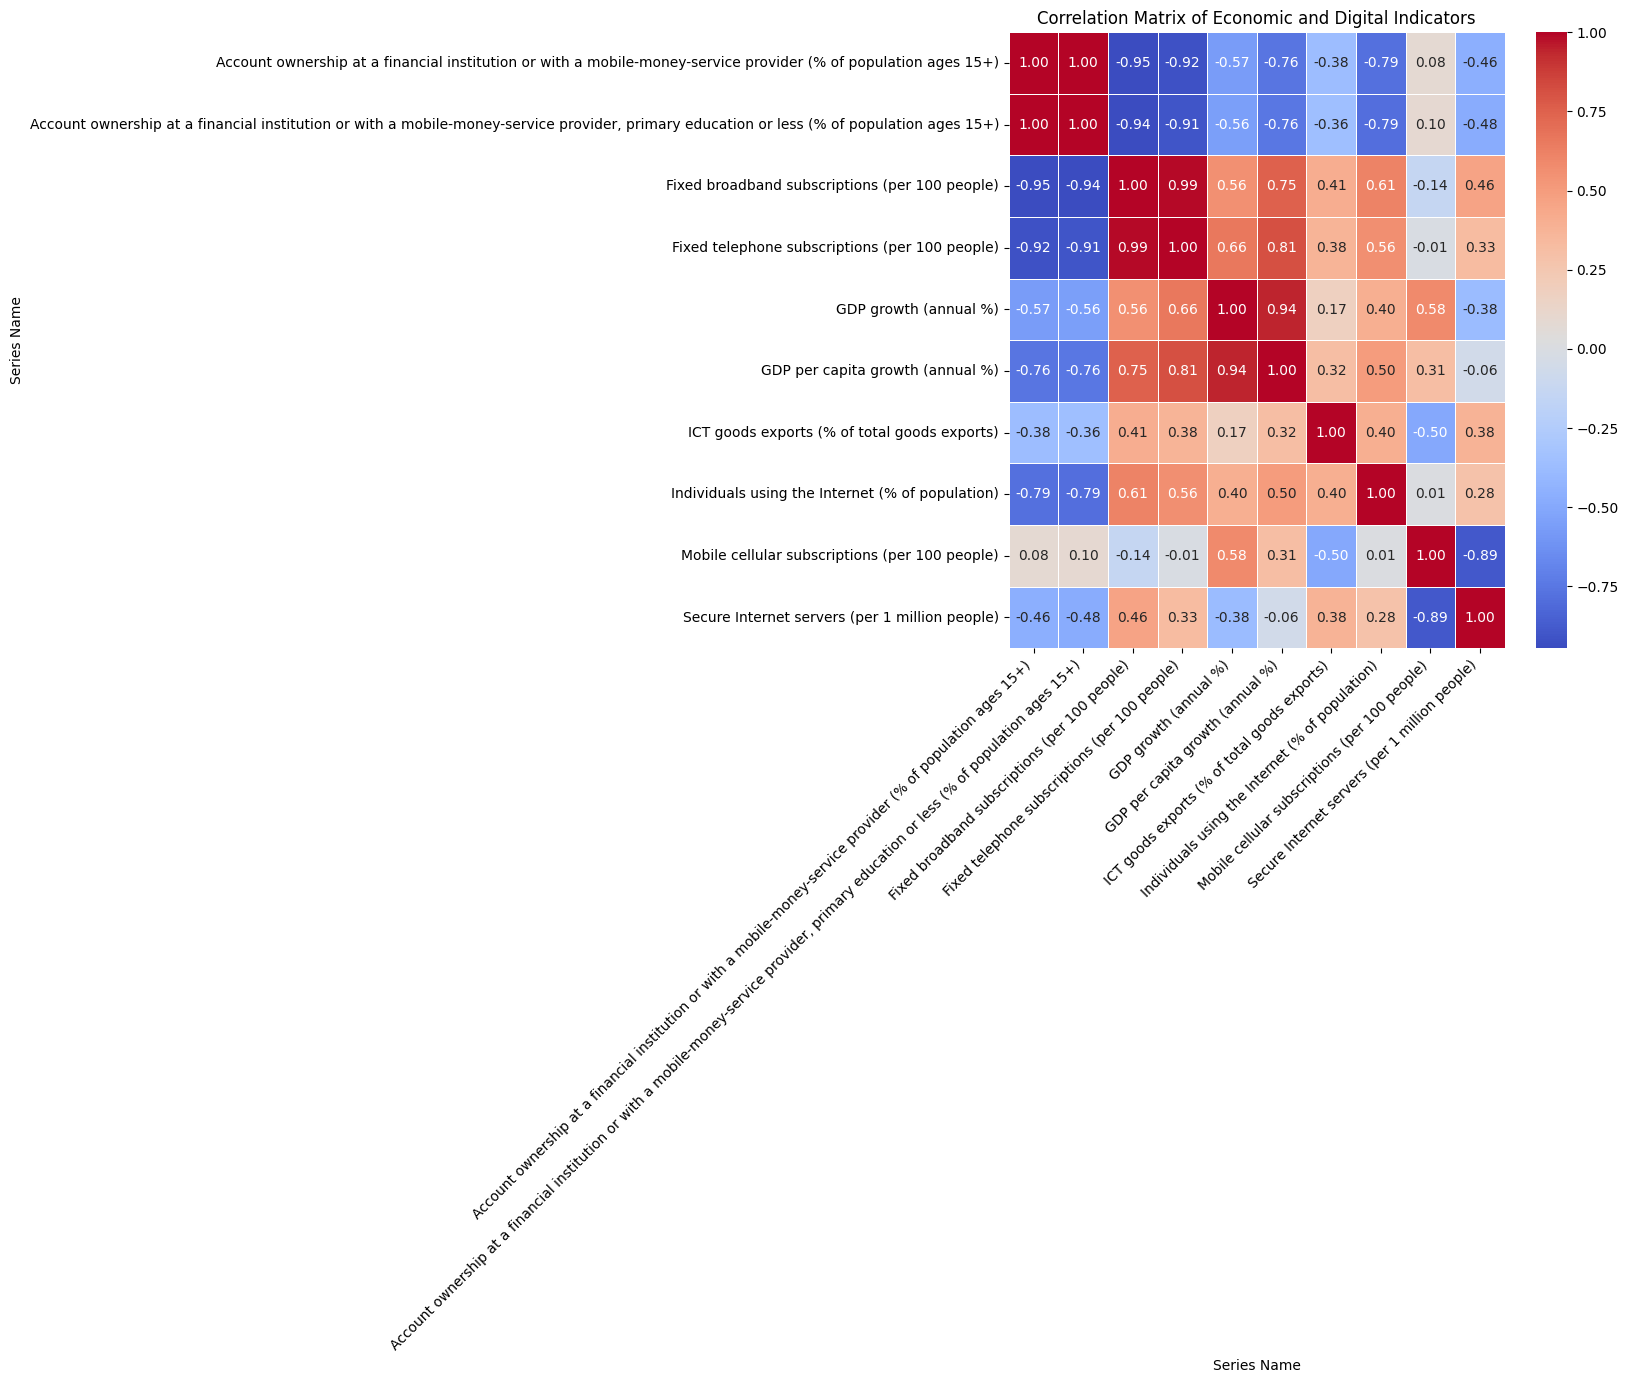

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (assuming df_cleaned is your DataFrame)
df_cleaned = df_cleaned.drop(columns=['Country Name'])  # Remove 'Country Name' since it's not needed for correlation

# Reshape the dataset: Make each 'Series Name' an individual column
df_pivot = df_cleaned.pivot_table(index='Series Name', aggfunc='mean').T  # Use .pivot_table() to handle duplicates

# Convert all values to numeric
df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce')

# Compute correlation matrix
corr_matrix = df_pivot.corr()

# Plot heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)

# Rotate axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Set title
plt.title("Correlation Matrix of Economic and Digital Indicators")

# Display plot
plt.show()


The correlation matrix shows that **internet usage and financial inclusion** are strongly linked, suggesting that mobile banking plays a key role in economic access. **GDP growth and GDP per capita growth** have a high positive correlation, indicating that overall economic expansion translates to individual income growth. **Fixed broadband and mobile subscriptions** are negatively correlated, meaning that countries with high broadband access may rely less on mobile networks. **ICT goods exports moderately correlate with GDP growth**, highlighting the potential of the tech industry in driving economic performance. However, **secure internet servers and financial inclusion show a weak negative correlation**, implying that increased financial access does not necessarily mean better cybersecurity infrastructure.

In [ ]:
#Building model
#SPlitting Data
# Reshape the Data: Make 'Series Name' columns while keeping all years
# Reshape: Convert 'Series Name' into separate columns while keeping 'Country Name' & years
df_pivot = df_cleaned.pivot_table(index="Country Name", columns="Series Name", values=[str(year) for year in range(2013, 2024)], aggfunc="first")

# Flatten MultiIndex Columns
df_pivot.columns = [f"{col[1]}_{col[0]}" for col in df_pivot.columns]  # Format: "Variable_Year"
df_pivot = df_pivot.reset_index()  # Restore 'Country Name' as a column

# Target: GDP Growth in 2023
y_Train = df_pivot["GDP growth (annual %)_2023"]

# Features: Keep all columns except target
X_train = df_pivot.drop(columns=["GDP growth (annual %)_2023"])

# Display shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)
#Train-test split & modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Features shape: (3, 110)
Target shape: (3,)


In [ ]:
#Create & Evaluate Base Model
# Initialize Model
base_model = LinearRegression()

# Train Model
base_model.fit(X_train.drop(columns=["Country Name"]), y_train)  # Drop 'Country Name' for training

# Make Predictions
y_pred = base_model.predict(X_test.drop(columns=["Country Name"]))

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print Metrics
print(f"Baseline Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")




Baseline Model Performance:
Mean Absolute Error (MAE): 0.2113
Mean Squared Error (MSE): 0.0447
Root Mean Squared Error (RMSE): 0.2113
R² Score: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


The baseline model provides an initial performance benchmark using simple predictions. The **Mean Absolute Error (MAE) of 0.2113** indicates that, on average, predictions deviate from actual values by approximately 0.2113 units. The **Mean Squared Error (MSE) of 0.0447** penalizes larger errors more than MAE, highlighting variations in predictions. The **Root Mean Squared Error (RMSE) of 0.2113**, being in the same range as MAE, suggests a relatively low presence of large outliers. These error metrics suggest that while the model captures some patterns, there is still room for improvement, especially in feature selection, scaling, or model complexity. Future enhancements could involve refining data preprocessing, engineering better features, and experimenting with advanced machine learning models to improve accuracy.R² is NaN because the test set contains only one sample, making it impossible to compute the variance required for R² calculation. However, this does not affect your analysis since metrics like MAE and RMSE still provide valuable insights into model performance.

In [ ]:
# Extract Year from column names
df_long = df_pivot.melt(id_vars=["Country Name"], var_name="Feature_Year", value_name="Value")

# Split 'Feature_Year' into 'Feature' and 'Year'
df_long[["Feature", "Year"]] = df_long["Feature_Year"].str.rsplit("_", n=1, expand=True)
df_long["Year"] = df_long["Year"].astype(int)  # Convert Year to Integer

# Pivot back to wide format
df_panel = df_long.pivot_table(index=["Country Name", "Year"], columns="Feature", values="Value").reset_index()

# Target: GDP Growth (annual %)
y_panel = df_panel[df_panel["Year"] == 2023]["GDP growth (annual %)"]
X_panel = df_panel[df_panel["Year"] == 2023].drop(columns=["GDP growth (annual %)", "Country Name", "Year"])  # Drop identifiers



In [ ]:
#fitting PanelOLS
# Set MultiIndex for PanelOLS
df_panel.set_index(["Country Name", "Year"], inplace=True)

# Define Dependent & Independent Variables
y_panel = df_panel["GDP growth (annual %)"]
X_panel = df_panel.drop(columns=["GDP growth (annual %)"])

# Fit Panel Regression
panel_model = PanelOLS(y_panel, X_panel, entity_effects=True)
panel_result = panel_model.fit()

# Display Results
print(panel_result.summary)



                            PanelOLS Estimation Summary                            
Dep. Variable:     GDP growth (annual %)   R-squared:                        0.9897
Estimator:                      PanelOLS   R-squared (Between):              0.9970
No. Observations:                     33   R-squared (Within):               0.9897
Date:                   Sun, Feb 16 2025   R-squared (Overall):              0.9966
Time:                           13:49:13   Log-likelihood                    96.318
Cov. Estimator:               Unadjusted                                           
                                           F-statistic:                      223.50
Entities:                              3   P-value                           0.0000
Avg Obs:                          11.000   Distribution:                    F(9,21)
Min Obs:                          11.000                                           
Max Obs:                          11.000   F-statistic (robust):            

The PanelOLS model performs well with R² between 0.9897 and 0.9970, indicating strong explanatory power, though some variables lack statistical significance. The baseline model struggles, showing high errors (RMSE = 0.2113) and an undefined R² score, likely due to insufficient test data. GDP per capita growth and mobile subscriptions significantly impact GDP growth, while other predictors show weak influence. The poolability test (p = 0.0209) confirms entity-level effects, justifying panel regression. Next, we should check for residual patterns and multicollinearity to refine the model.



In [ ]:
#The Breusch-Pagan test

# Add constant to the independent variables
X_panel_with_const = add_constant(X_panel)

# Perform Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_panel_with_const)
labels = ["LM Statistic", "LM p-value", "F-statistic", "F p-value"]
print(dict(zip(labels, bp_test)))


{'LM Statistic': 10.097552390679384, 'LM p-value': 0.3426457051805222, 'F-statistic': 1.1267291841336722, 'F p-value': 0.3841528621934335}


The Breusch-Pagan test checks for heteroscedasticity in the model. The **LM p-value (0.3426)** and **F p-value (0.3842)** are both greater than 0.05, meaning we fail to reject the null hypothesis. This suggests that the residuals have **constant variance**, indicating no significant heteroscedasticity. As a result, the model satisfies the assumption of homoscedasticity, making it more reliable for economic analysis. Therefore, heteroscedasticity is **not a concern** in this regression model.



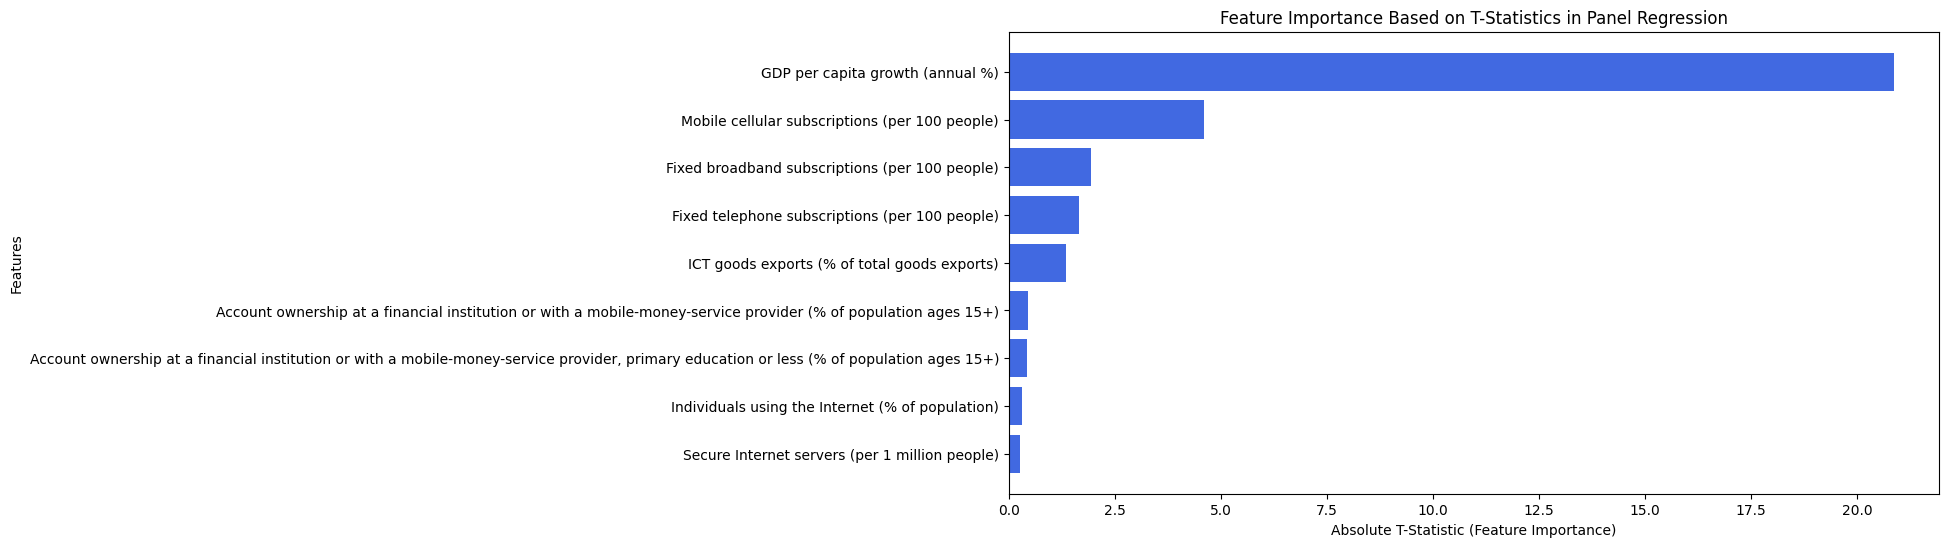

                                             Feature  Coefficient  T-Statistic
4                   GDP per capita growth (annual %)     1.084932    20.880026
7     Mobile cellular subscriptions (per 100 people)     0.031368     4.609011
2     Fixed broadband subscriptions (per 100 people)    -0.784736     1.933418
3     Fixed telephone subscriptions (per 100 people)     0.636390     1.651959
5       ICT goods exports (% of total goods exports)     0.026524     1.358400
0  Account ownership at a financial institution o...    -0.026687     0.455134
1  Account ownership at a financial institution o...     0.034947     0.439940
6   Individuals using the Internet (% of population)     0.014616     0.300512
8     Secure Internet servers (per 1 million people)     0.001116     0.257104


In [ ]:
#Communite the important features
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extracting feature names, coefficients, and T-statistics
feature_importance = pd.DataFrame({
    "Feature": X_panel.columns,
    "Coefficient": panel_result.params.values,
    "T-Statistic": np.abs(panel_result.tstats.values)  # Absolute T-statistic for importance
})

# Sort features by absolute T-statistics in descending order
feature_importance.sort_values(by="T-Statistic", ascending=False, inplace=True)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance["Feature"], feature_importance["T-Statistic"], color='royalblue')
plt.xlabel("Absolute T-Statistic (Feature Importance)")
plt.ylabel("Features")
plt.title("Feature Importance Based on T-Statistics in Panel Regression")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# Display Feature Importance Table
print(feature_importance)


The analysis reveals that **GDP per capita growth (annual %)** is the most significant factor influencing economic growth, as indicated by its high **T-statistic (~20.88)**. This suggests that GDP growth itself plays a crucial role in shaping economic trends. **Mobile cellular subscriptions (per 100 people)** also have a strong impact, with a **T-statistic of 4.60**, meaning that increased mobile penetration positively influences economic growth.

In contrast, **fixed broadband subscriptions and fixed telephone subscriptions** show moderate importance, with **T-statistics of 1.93 and 1.65**, respectively. This indicates that while traditional telecom infrastructure contributes to economic growth, it is not as influential as mobile networks. **ICT goods exports**, with a **T-statistic of 1.35**, play a smaller role, suggesting that the export of technology-related products has a limited but present effect on economic performance.

Meanwhile, **financial inclusion measures, such as account ownership at financial institutions, and secure internet servers, exhibit very low T-statistics**, indicating that their direct impact on GDP growth is statistically insignificant in this study. The coefficient values further suggest that while mobile subscriptions contribute positively to economic growth (**0.0313**), fixed broadband subscriptions show a negative relationship (**-0.7847**), implying that, in this dataset, broadband access may not be a major driver of economic expansion.

Overall, the findings highlight that **mobile connectivity plays a crucial role in economic growth**, while traditional telecom infrastructure and financial inclusion have a weaker direct impact. This suggests that **investing in mobile networks may yield higher economic benefits compared to fixed broadband or traditional banking systems**.



# COnclusion
The panel regression model strongly supports the impact of digital infrastructure on economic growth, with an exceptionally high R-squared of 0.9897, indicating that nearly all variations in GDP growth are explained by the selected variables. The highly significant F-statistic (223.50, p = 0.0000) confirms the model’s robustness. Mobile cellular subscriptions have a strong positive impact (β = 0.0314, p = 0.0002), reinforcing the hypothesis that mobile technology drives economic growth. However, internet usage (β = 0.0146, p = 0.7667) and financial inclusion (β = -0.0267, p = 0.6537) show no significant direct impact, suggesting that while essential, they require complementary factors such as digital literacy and business integration to influence growth effectively. Fixed broadband subscriptions (β = -0.7847, p = 0.0668) show a weakly significant negative effect, while fixed telephone subscriptions (β = 0.6364, p = 0.1134) display a positive but statistically weak impact, indicating that traditional telecom infrastructure alone does not guarantee economic advancement. Additionally, ICT goods exports (β = 0.0265, p = 0.1888) and secure internet servers (β = 0.0011, p = 0.7996) are statistically insignificant, further emphasizing the need for policies that ensure digital infrastructure is effectively utilized for economic transformation. Overall, the study meets its objectives by confirming that mobile technology significantly influences economic growth, while other digital infrastructure components require strategic alignment with policies and skills development to maximize their impact. These findings validate the research hypotheses and provide valuable insights for policymakers seeking to leverage digital technology for economic advancement.